# 导入所需模块

In [1]:
!pip install tensorflow==2.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 702.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorf

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


# 数据预处理

### **数据读入和存储**

In [3]:
# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
df

,filepaths,labels
0,/kaggle/input/brain-mri-images-for-brain-tumor...,no
1,/kaggle/input/brain-mri-images-for-brain-tumor...,no
2,/kaggle/input/brain-mri-images-for-brain-tumor...,no
3,/kaggle/input/brain-mri-images-for-brain-tumor...,no
4,/kaggle/input/brain-mri-images-for-brain-tumor...,no
...,...,...
250,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
251,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
252,/kaggle/input/brain-mri-images-for-brain-tumor...,yes
253,/kaggle/input/brain-mri-images-for-brain-tumor...,brain_tumor_dataset


### **划分数据集**

In [5]:
strat = df['labels']
train_df, test_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

### **创建图像数据生成器**

In [6]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.


### **显示训练集样本**

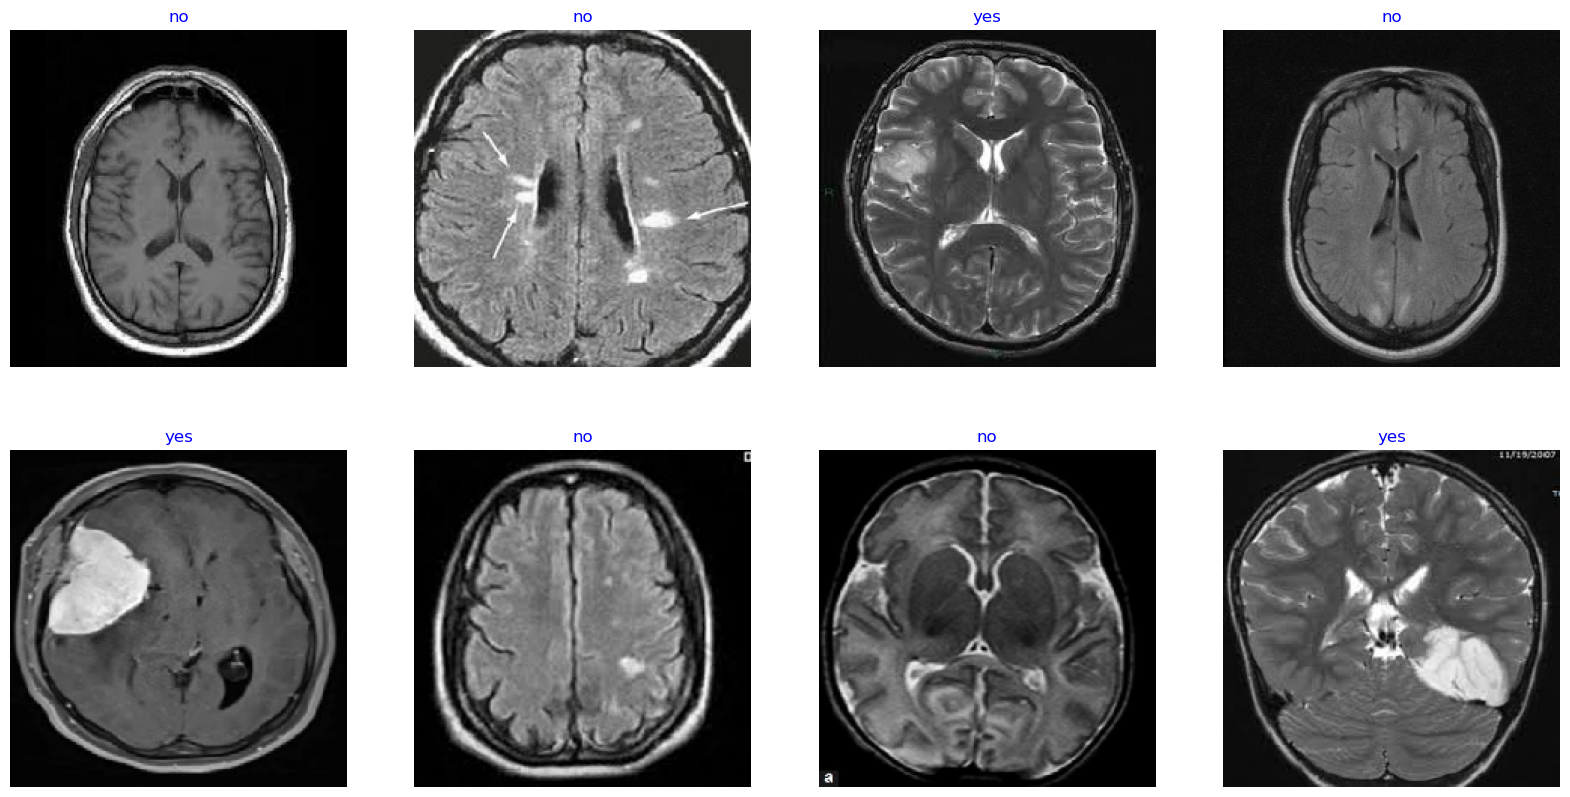

In [7]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 10))

for i in range(8):
    plt.subplot(2, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# **模型构建**

#### **通用模型创建**

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", 
                                                               input_shape= img_shape, pooling= 'max')


model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
#     Dense(128, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
#                 bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
#     Dropout(rate= 0.45, seed= 123),
    Dropout(rate= 0.25, seed= 123),
    Dense(class_count, activation= 'softmax')
])


model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])
#model.compile(Adamax(learning_rate= 0.001), loss= 'binary_crossentropy', metrics= ['accuracy'])
#model.compile(optimizer=Adamax(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non

#### **训练模型**

In [9]:
epochs = 30   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen, 
                    validation_steps= None, shuffle= False)

Epoch 1/30
26/26 [==============================] - 24s 272ms/step - loss: 8.1022 - accuracy: 0.7673 - val_loss: 9.0252 - val_accuracy: 0.6275
Epoch 2/30
26/26 [==============================] - 4s 145ms/step - loss: 7.1117 - accuracy: 0.8366 - val_loss: 7.9887 - val_accuracy: 0.6667
Epoch 3/30
26/26 [==============================] - 4s 144ms/step - loss: 6.3786 - accuracy: 0.8713 - val_loss: 7.2261 - val_accuracy: 0.6863
Epoch 4/30
26/26 [==============================] - 4s 141ms/step - loss: 5.8335 - accuracy: 0.9109 - val_loss: 6.5259 - val_accuracy: 0.6863
Epoch 5/30
26/26 [==============================] - 4s 143ms/step - loss: 5.2939 - accuracy: 0.9604 - val_loss: 5.8360 - val_accuracy: 0.7647
Epoch 6/30
26/26 [==============================] - 4s 144ms/step - loss: 5.0379 - accuracy: 0.9455 - val_loss: 5.1029 - val_accuracy: 0.8431
Epoch 7/30
26/26 [==============================] - 4s 143ms/step - loss: 4.7325 - accuracy: 0.9356 - val_loss: 4.8652 - val_accuracy: 0.8824
Epoch

#### **显示模型性能**

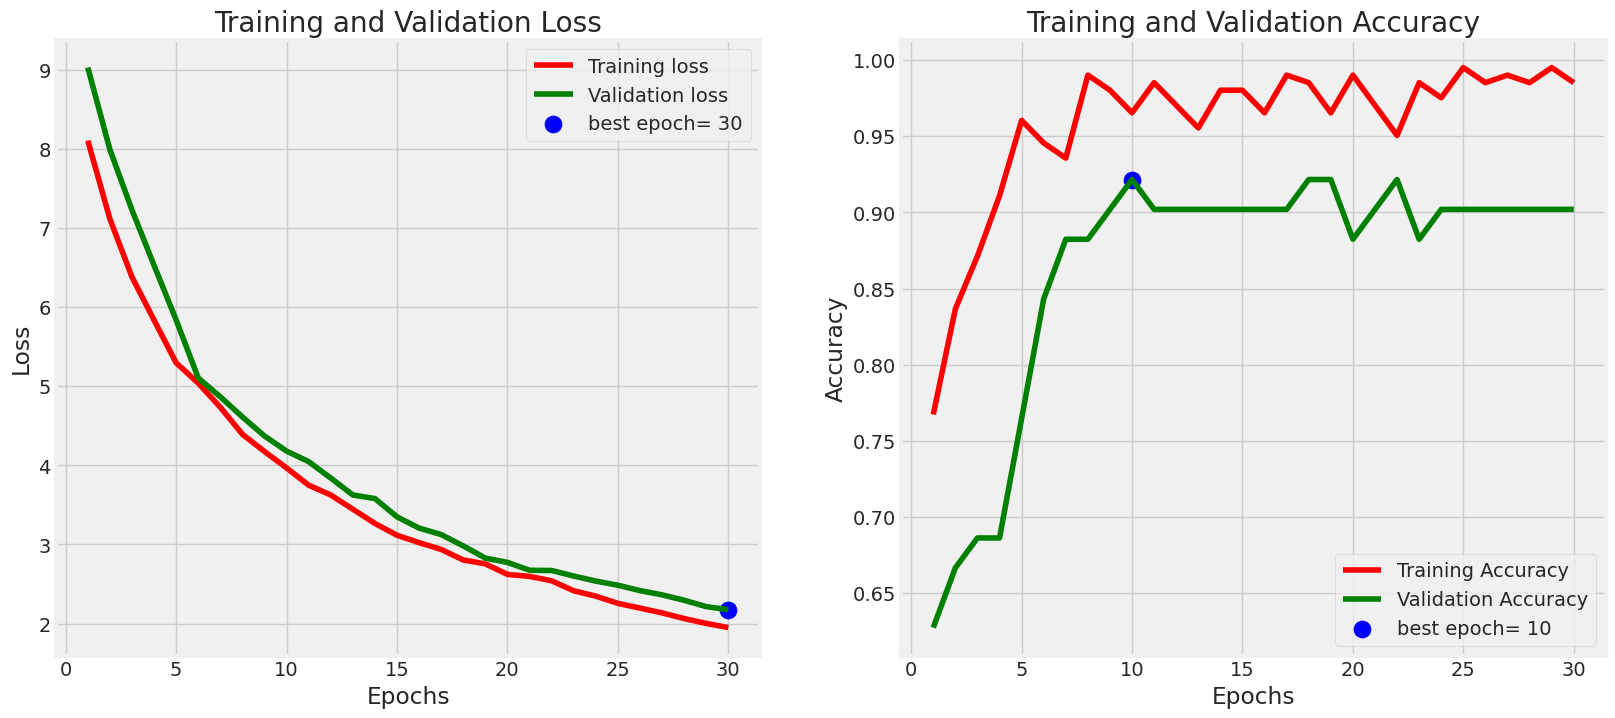

In [10]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# **评估模型**

In [11]:
train_score = model.evaluate(train_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

7/7 [==============================] - 0s 28ms/step - loss: 2.1747 - accuracy: 0.9020
Train Loss:  1.908083200454712
Train Accuracy:  1.0
--------------------
Test Loss:  2.1746935844421387
Test Accuracy:  0.9019607901573181


# **预测**

In [12]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

#### **混淆矩阵及分类报告**

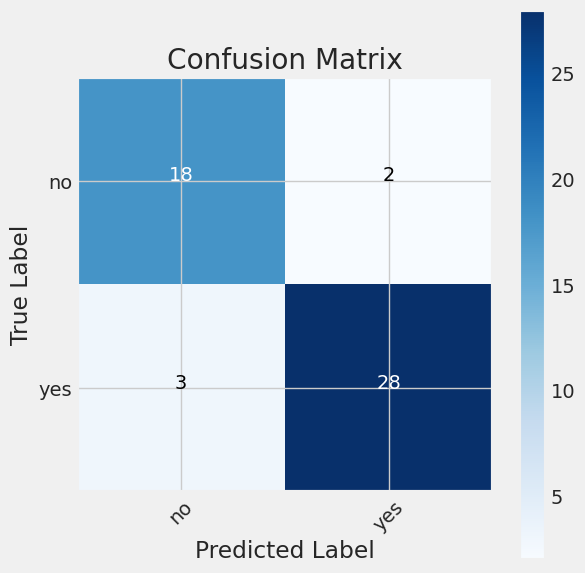

In [13]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (6, 6))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [14]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

          no       0.86      0.90      0.88        20
         yes       0.93      0.90      0.92        31

    accuracy                           0.90        51
   macro avg       0.90      0.90      0.90        51
weighted avg       0.90      0.90      0.90        51



#### **保存模型**

In [15]:
#Save the model
model.save('Model.h5')

**模型应用**

In [16]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# 加载保存的模型
model = tf.keras.models.load_model('/kaggle/working/Model.h5')

# 定义一个函数来加载和预处理图像
def load_and_preprocess_image(image_path):
    # 加载图像
    img = image.load_img(image_path, target_size=(224, 224))
    # 转换图像为张量
    img_tensor = image.img_to_array(img)
    # 添加一个维度以表示批量
    img_tensor = np.expand_dims(img_tensor, axis=0)
    # 预处理图像（例如，标准化）
    # 这里需要根据您的模型架构和预处理步骤来调整
    # img_tensor = preprocess_input(img_tensor)
    return img_tensor

# 定义一个函数来预测图像是否含有脑肿瘤
def predict_brain_tumor(image_path):
    # 加载并预处理图像
    img_tensor = load_and_preprocess_image(image_path)
    # 使用模型进行预测
    prediction = model.predict(img_tensor)
    # 获取预测结果的标签
    predicted_label = np.argmax(prediction[0])
    # 根据预测结果判断是否含有脑肿瘤
    if predicted_label == 1:
        return "脑肿瘤"
    else:
        return "无脑肿瘤"

# 给定几副图像路径进行预测
image_paths = ['/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/1 no.jpeg', '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/37 no.jpg', '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y117.JPG','/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg']

# 循环预测每个图像
for image_path in image_paths:
    result = predict_brain_tumor(image_path)
    print(f"{image_path}: {result}")

1/1 [==============================] - 3s 3s/step
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/1 no.jpeg: 无脑肿瘤
1/1 [==============================] - 0s 34ms/step
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/37 no.jpg: 无脑肿瘤
1/1 [==============================] - 0s 33ms/step
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y117.JPG: 脑肿瘤
1/1 [==============================] - 0s 33ms/step
/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/Y1.jpg: 脑肿瘤


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 reshape (Reshape)           (None, 7, 10752)          0         
                                                                 
 time_distributed (TimeDistr  (None, 7, 256)           2752768   
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 128)               197120    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
 

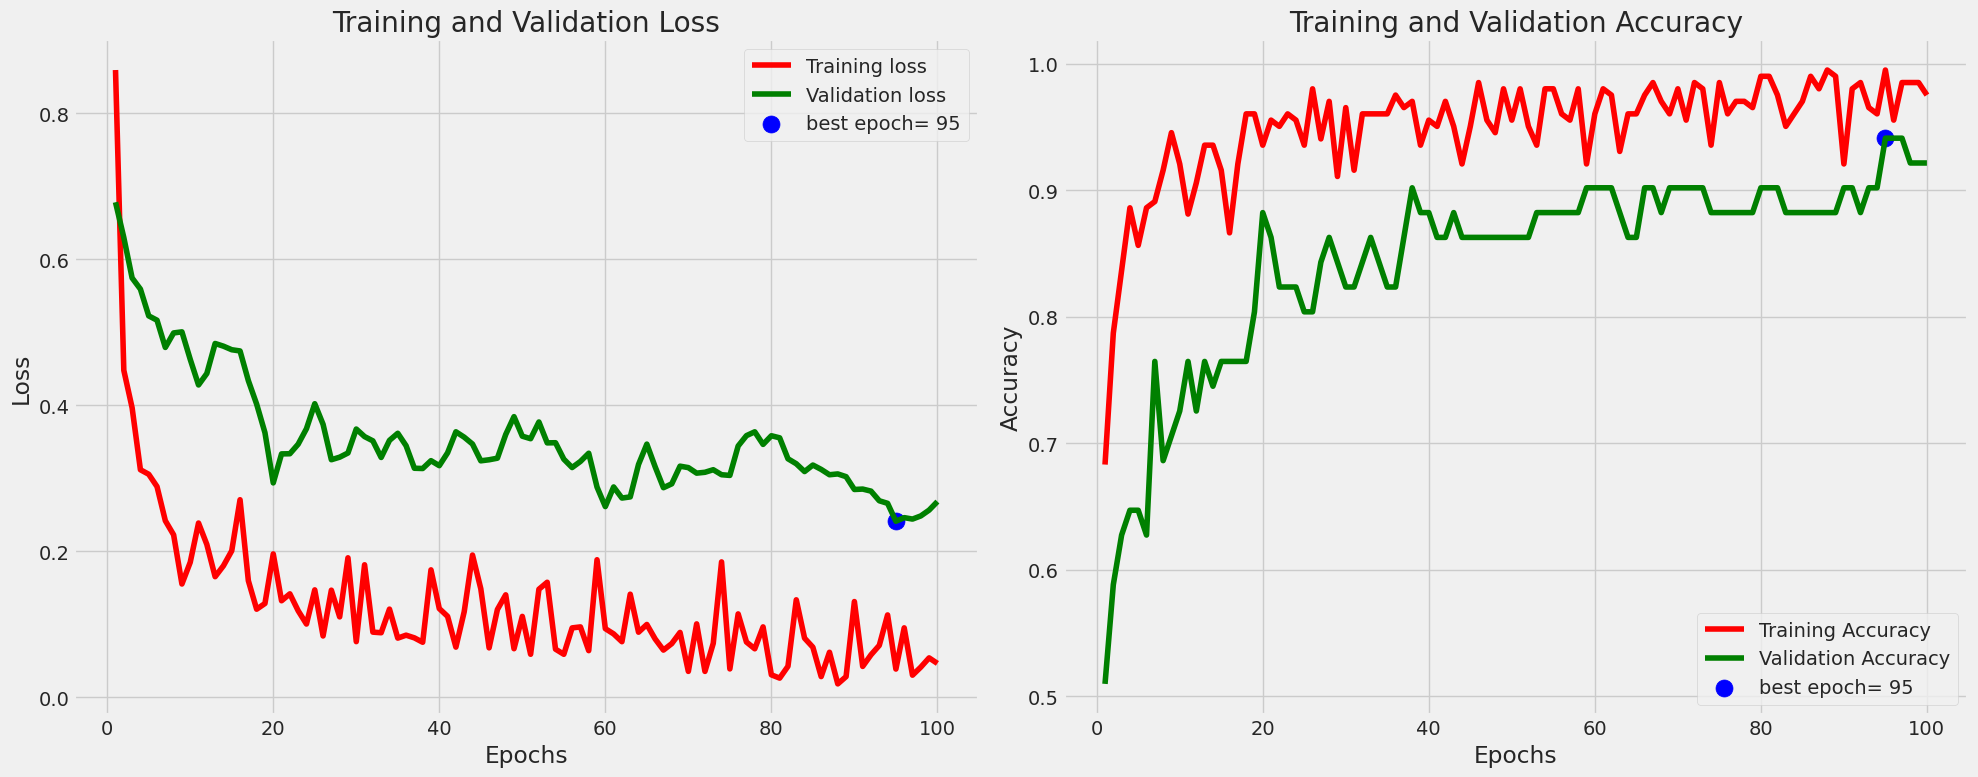

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Image data generator
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Create Model Structure
class_count = len(list(train_gen.class_indices.keys()))  # number of classes

# Pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling=None)

model = Sequential([
    base_model,
    Reshape((base_model.output_shape[1], -1)),  # Reshape to (batch_size, time_steps, features)
    TimeDistributed(Dense(256, activation='relu')),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.25, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
epochs = 100
history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=test_gen, validation_steps=None, shuffle=False)

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 reshape_1 (Reshape)         (None, 7, 10752)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 7, 256)           2752768   
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 batch_normalization_2 (Batc  (None, 128)              512       
 hNormalization)                                                 
 

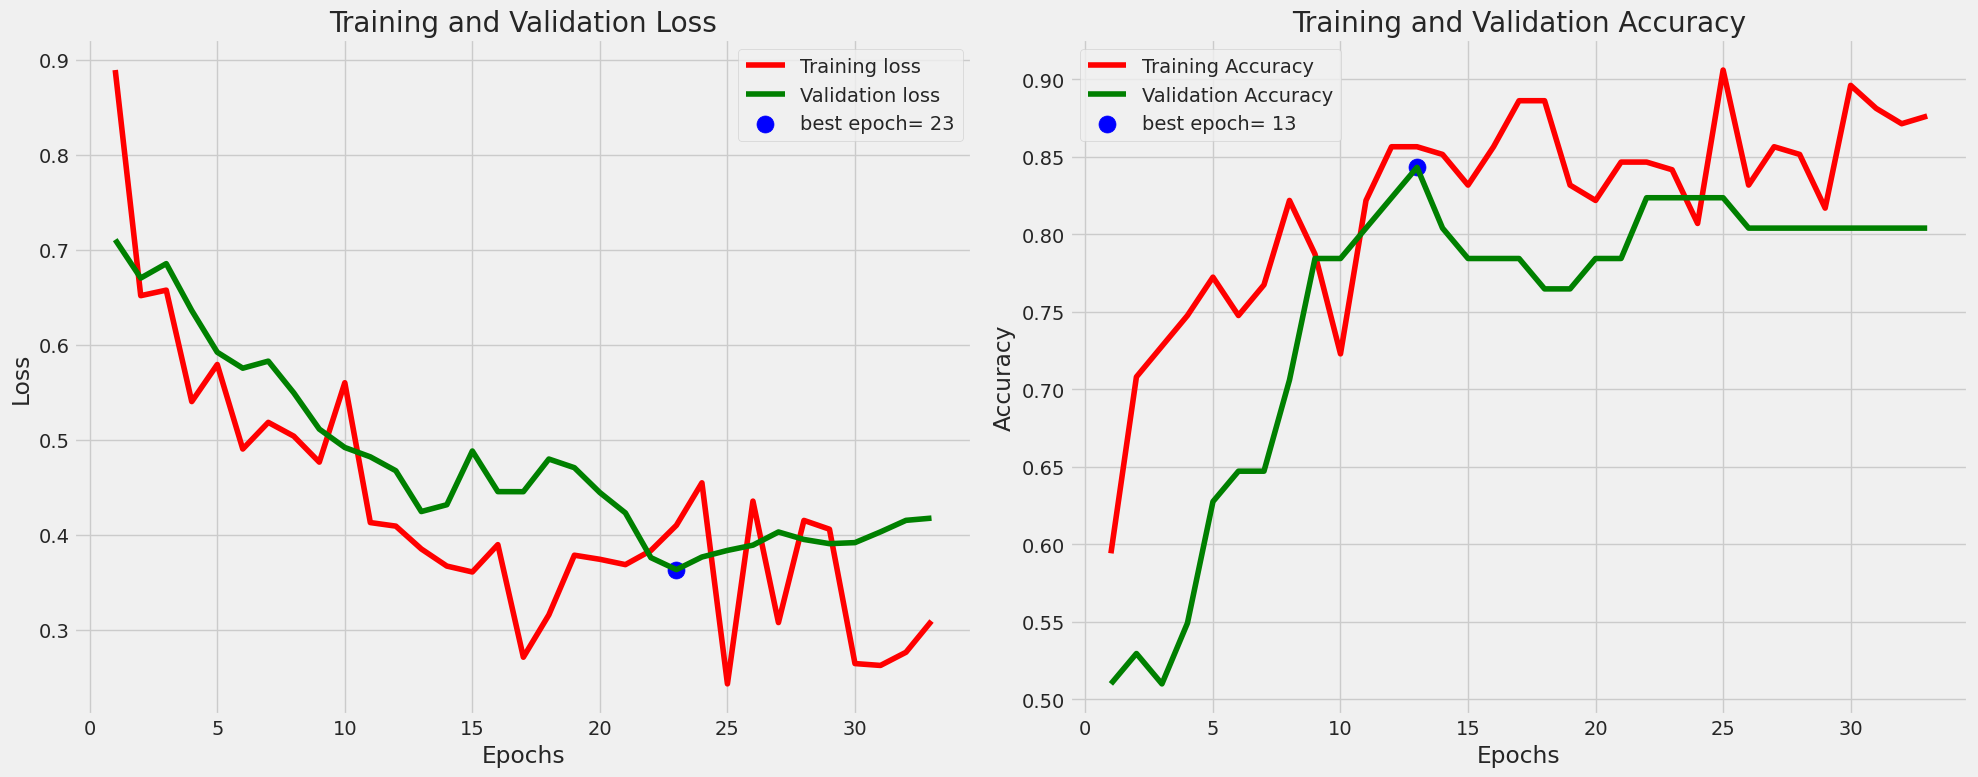

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Reshape
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Image data generator with augmentation
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Create Model Structure
class_count = len(list(train_gen.class_indices.keys()))  # number of classes

# Pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling=None)

model = Sequential([
    base_model,
    Reshape((base_model.output_shape[1], -1)),  # Reshape to (batch_size, time_steps, features)
    TimeDistributed(Dense(256, activation='relu')),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.25, seed=123),
    Dense(class_count, activation='softmax')
])

model.compile(Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
epochs = 100
history = model.fit(
    x=train_gen, 
    epochs=epochs, 
    verbose=1, 
    validation_data=test_gen, 
    validation_steps=None, 
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               786944    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
 

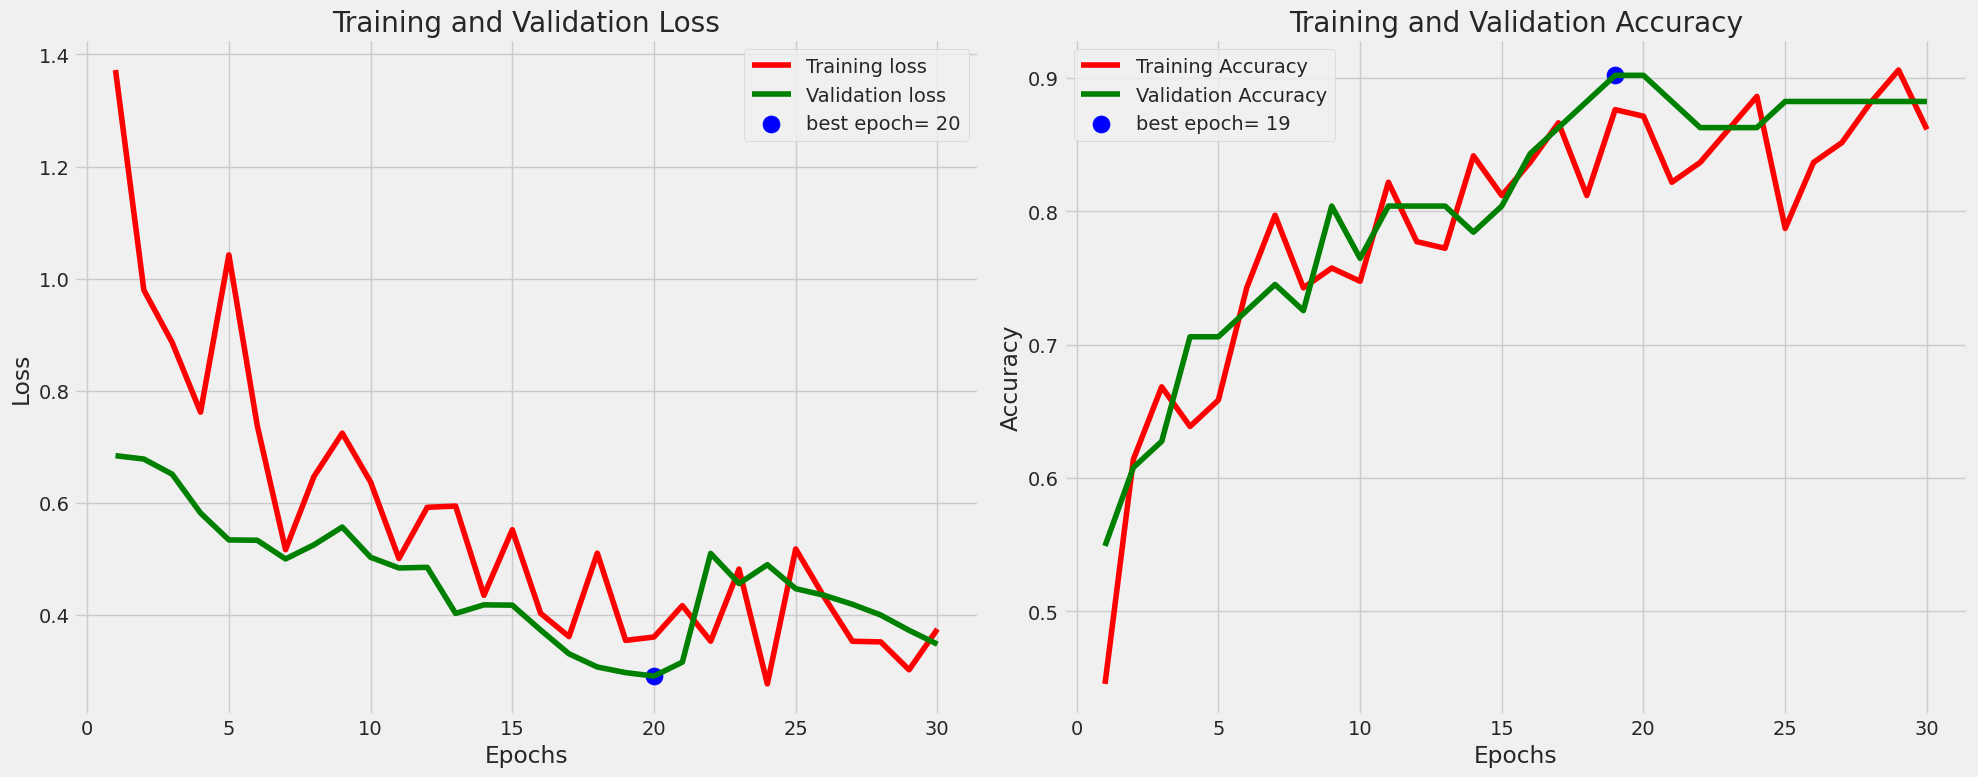

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Reshape, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Image data generator with augmentation
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Create Model Structure
class_count = len(list(train_gen.class_indices.keys()))  # number of classes

# Pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling=None)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
epochs = 100
history = model.fit(
    x=train_gen, 
    epochs=epochs, 
    verbose=1, 
    validation_data=test_gen, 
    validation_steps=None, 
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the classes for the test set
test_gen.reset()
preds = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1, verbose=1)

# Convert the predicted probabilities to class labels
pred_labels = np.argmax(preds, axis=1)

# Get the true labels from the test generator
true_labels = test_gen.classes

# Get the class indices from the generator
class_indices = test_gen.class_indices
class_names = list(class_indices.keys())

# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)


7/7 [==============================] - 2s 26ms/step
              precision    recall  f1-score   support

          no       0.89      0.85      0.87        20
         yes       0.91      0.94      0.92        31

    accuracy                           0.90        51
   macro avg       0.90      0.89      0.90        51
weighted avg       0.90      0.90      0.90        51



Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 512)               786944    
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
 

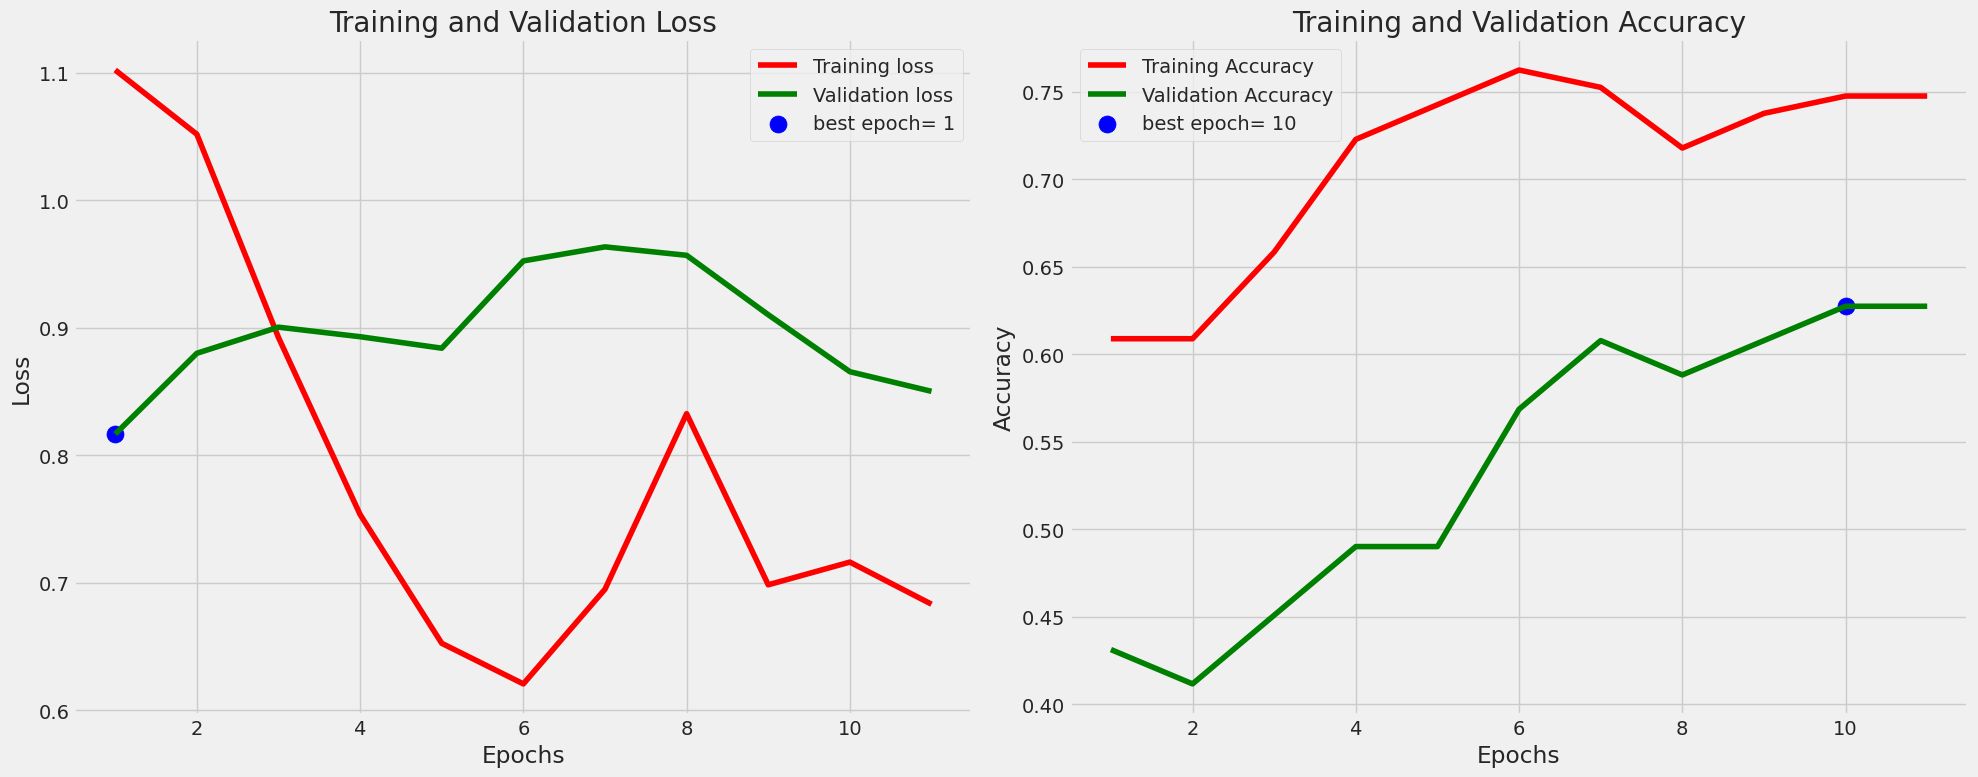

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LSTM, TimeDistributed, Reshape, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers

# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Image data generator with augmentation
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Create Model Structure
class_count = len(list(train_gen.class_indices.keys()))  # number of classes

# Pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling=None)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
epochs = 100
history = model.fit(
    x=train_gen, 
    epochs=epochs, 
    verbose=1, 
    validation_data=test_gen, 
    validation_steps=None, 
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Found 202 validated image filenames belonging to 2 classes.
Found 51 validated image filenames belonging to 2 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d_2   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 512)               786944    
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
 

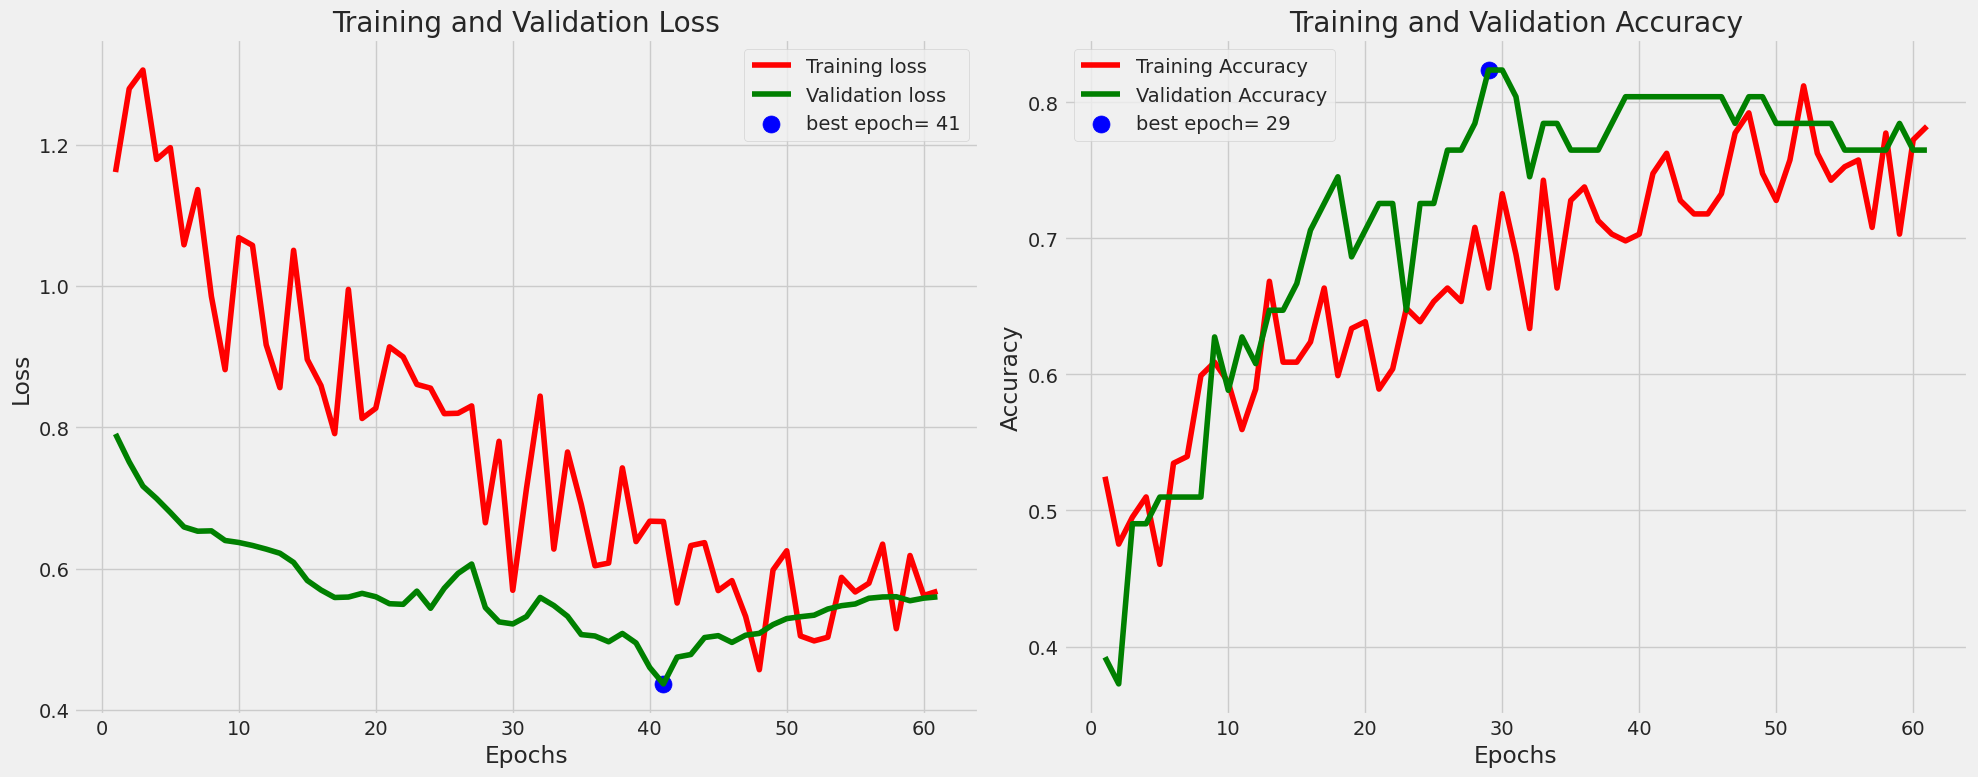

4/4 [==============================] - 3s 48ms/step
              precision    recall  f1-score   support

          no       0.71      0.85      0.77        20
         yes       0.89      0.77      0.83        31

    accuracy                           0.80        51
   macro avg       0.80      0.81      0.80        51
weighted avg       0.82      0.80      0.81        51



In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Image data generator with augmentation
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Create Model Structure
class_count = len(list(train_gen.class_indices.keys()))  # number of classes

# Pre-trained model
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling=None)

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(class_count, activation='softmax')
])

model.compile(SGD(learning_rate=0.0001, momentum=0.8), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
epochs = 100
history = model.fit(
    x=train_gen, 
    epochs=epochs, 
    verbose=1, 
    validation_data=test_gen, 
    validation_steps=None, 
    shuffle=False,
    callbacks=[early_stopping, reduce_lr]
)

# Plot training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Generate classification report
test_gen.reset()
preds = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1, verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_gen.classes
class_indices = test_gen.class_indices
class_names = list(class_indices.keys())

report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)


Trial 90 Complete [00h 01m 46s]
val_accuracy: 0.9215686321258545

Best val_accuracy So Far: 0.9607843160629272
Total elapsed time: 01h 23m 01s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 384)               590208    
                                                                 
 batch_normalization (BatchN  (None, 384)              1536      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 384)     

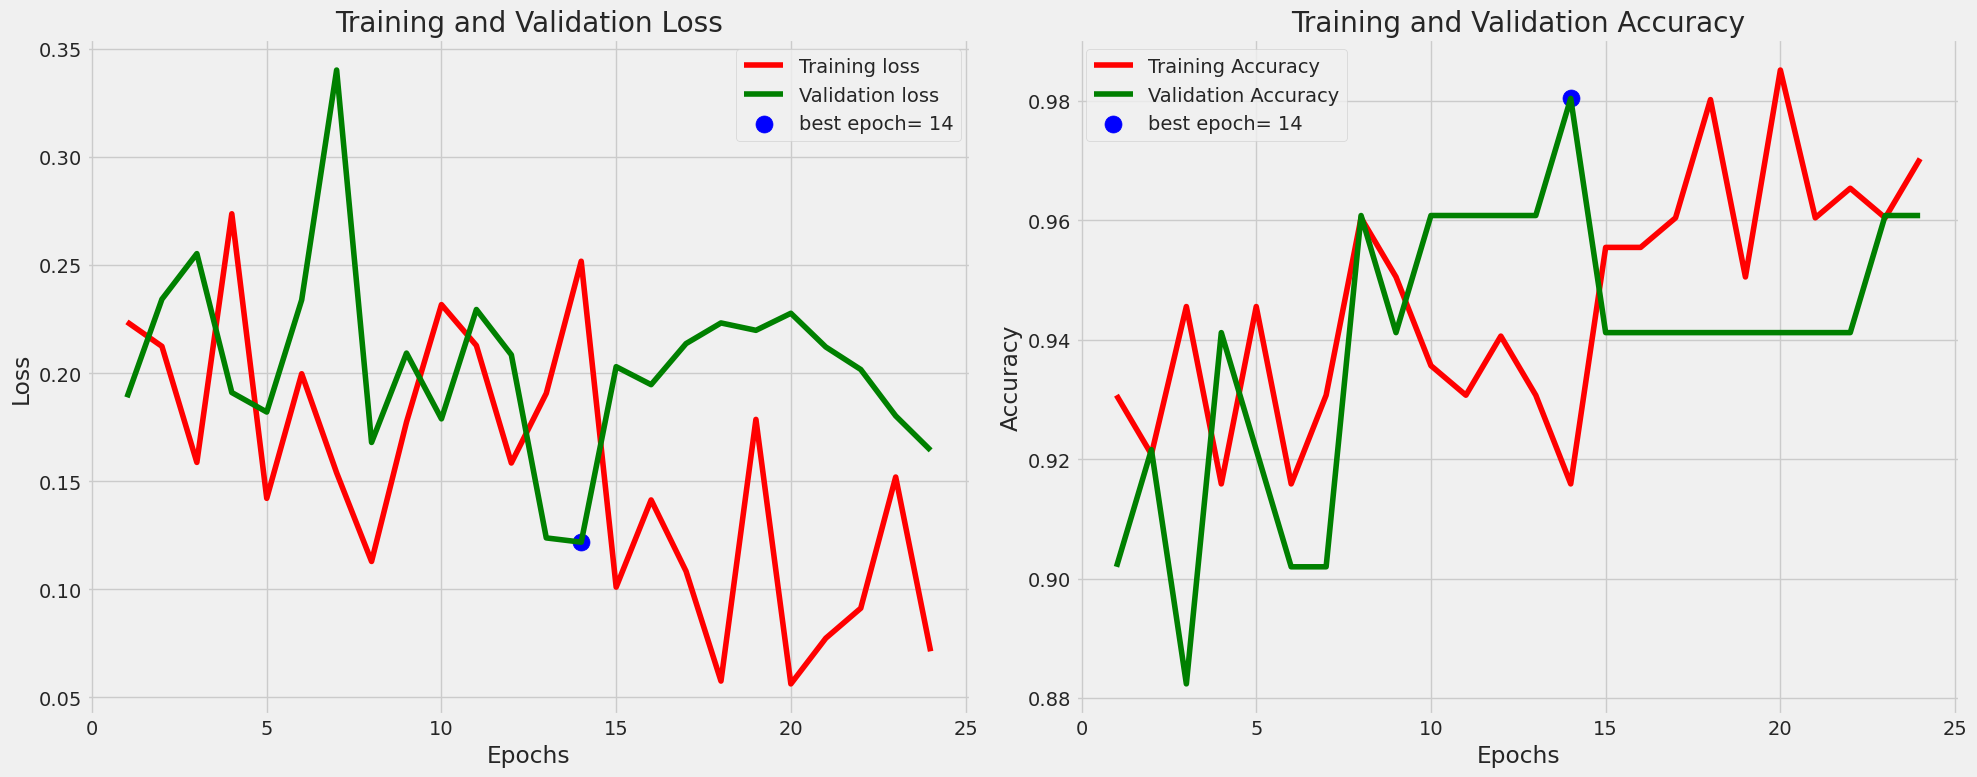

7/7 [==============================] - 2s 28ms/step
              precision    recall  f1-score   support

          no       1.00      0.95      0.97        20
         yes       0.97      1.00      0.98        31

    accuracy                           0.98        51
   macro avg       0.98      0.97      0.98        51
weighted avg       0.98      0.98      0.98        51



In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import kerastuner as kt

# Generate data paths with labels
data_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)
        
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)
strat = df['labels']
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)

# Image data generator with augmentation
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

# Define the hypermodel
def build_model(hp):
    base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling=None)
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    
    # Tune the number of units in the dense layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=32), activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_' + str(i), 0.2, 0.5, step=0.1)))

    model.add(Dense(class_count, activation='softmax'))
    
    # Tune the learning rate for the optimizer
    model.compile(
        optimizer=SGD(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'), momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Initialize the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='hyperband_dir',
    project_name='brain_tumor_detection'
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Perform the hyperparameter search
tuner.search(train_gen, epochs=50, validation_data=test_gen, callbacks=[early_stopping, reduce_lr])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Summary of the best model
best_model.summary()

# Train the best model
history = best_model.fit(train_gen, epochs=100, validation_data=test_gen, callbacks=[early_stopping, reduce_lr])

# Plot training history
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Generate classification report
test_gen.reset()
preds = best_model.predict(test_gen, steps=test_gen.n // test_gen.batch_size + 1, verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_gen.classes
class_indices = test_gen.class_indices
class_names = list(class_indices.keys())

report = classification_report(true_labels, pred_labels, target_names=class_names)
print(report)
